In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
data=pd.read_csv("co2_mm_mlo.csv")

In [6]:
data.head()

,year,month,decimal_date,average,interpolated
0,1958,3,1958.208,315.71,315.71
1,1958,4,1958.292,317.45,317.45
2,1958,5,1958.375,317.50,317.50
3,1958,6,1958.458,NaN,317.10
4,1958,7,1958.542,315.86,315.86


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          729 non-null    int64  
 1   month         729 non-null    int64  
 2   decimal_date  729 non-null    float64
 3   average       722 non-null    float64
 4   interpolated  729 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 28.6 KB


In [76]:
import warnings
warnings.filterwarnings("ignore")
# ignore harmless warnings

In [13]:
data["date"]=pd.to_datetime({"year":(data["year"]),"month":(data["month"]),"day":(1)})
#since we have year and month columns separately , considering them in a single column makes more sense!

In [14]:
data.head()

,year,month,decimal_date,average,interpolated,date
0,1958,3,1958.208,315.71,315.71,1958-03-01
1,1958,4,1958.292,317.45,317.45,1958-04-01
2,1958,5,1958.375,317.50,317.50,1958-05-01
3,1958,6,1958.458,NaN,317.10,1958-06-01
4,1958,7,1958.542,315.86,315.86,1958-07-01


In [16]:
data.set_index("date",inplace=True)
#let the date column be our index

In [17]:
data.head(2)

,year,month,decimal_date,average,interpolated
date,,,,,
1958-03-01,1958,3,1958.208,315.71,315.71
1958-04-01,1958,4,1958.292,317.45,317.45


In [18]:
data.index.freq="MS"

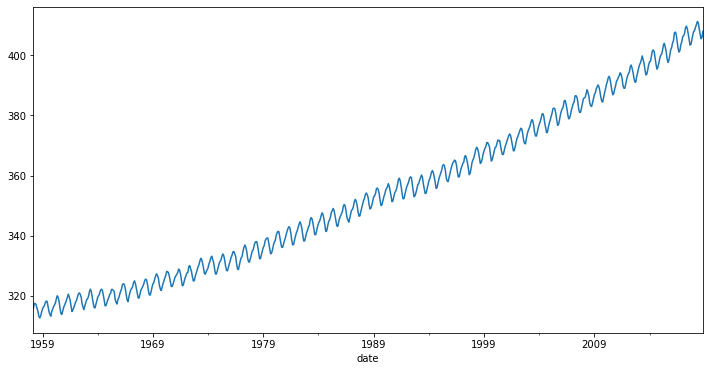

In [21]:
data["interpolated"].plot(figsize=(12,6))
plt.show()

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose
#for ETS plot and observing the trend and  seasonality pattern

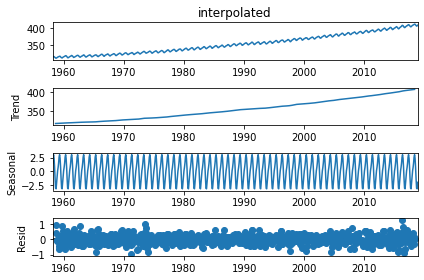

In [25]:
seasonal_decompose(data["interpolated"]).plot();

In [33]:
from statsmodels.tsa.stattools import adfuller
#augmented Dicky-fuller test!
#from ETS we realized that seasonality plays role in our dataset but lets examin it with dicky fuller test either!

In [34]:
adfuller(data["interpolated"])
#here p-valu is 1>0.05 ,we fail to reject the null hypothesis which leads us to this colculusion:"its non-stationary"

(4.9948472444039265,
 1.0,
 20,
 708,
 {'1%': -3.439620010600208,
  '5%': -2.8656309041017756,
  '10%': -2.5689484851894413},
 497.554472817601)

In [71]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
#for determining p and q

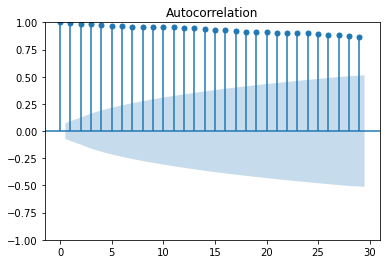

In [73]:
plot_acf(data["interpolated"]);

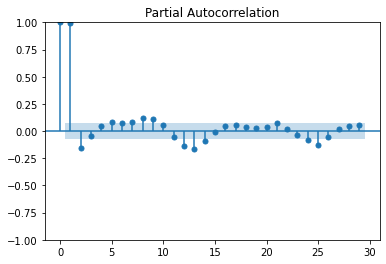

In [77]:
plot_pacf(data["interpolated"]);

In [26]:
from pmdarima import auto_arima

In [28]:
auto_arima(data["interpolated"],seasonal=True,m=12).summary()
#let the auto_arima make decision for us,it gives us the optimum model,order and seasonal order!

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  729
Model:             SARIMAX(0, 1, 3)x(1, 0, [1], 12)   Log Likelihood                -205.688
Date:                              Wed, 14 Dec 2022   AIC                            423.376
Time:                                      13:04:47   BIC                            450.918
Sample:                                  03-01-1958   HQIC                           434.003
                                       - 11-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3568      0.036     -9.806      0.000      -0.428      -0.286
ma.L2         -0.0217      0.034     -0.631      0.528      -0.089       0.046
ma.L3         -0.0838      0.032     -2.653      0.008      -0.146      -0.022
ar.S.L12       0.9996      0.000   3013.098      0.000       0.999       1.000
ma.S.L12      -0.8673      0.021    -41.089      0.000      -0.909      -0.826
sigma2         0.0953      0.005     20.409      0.000       0.086       0.104
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 4.08
Prob(Q):                              0.80   Prob(JB):                         0.13
Heteroskedasticity (H):               1.13   Skew:                             0.00
Prob(H) (two-sided):                  0.33   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [47]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [48]:
data.shape

(729, 5)

In [49]:
729-12

717

In [50]:
train=data.iloc[:717]
test=data.iloc[717:]
#I set one year for testing!

In [53]:
fitted_model=SARIMAX(train["interpolated"],order=(0,1,3),seasonal_order=(1,0,1,12)).fit()

In [65]:
prediction=fitted_model.predict(start=len(train),end=len(train)+len(test)-1,type="levels").rename("prediction")

<AxesSubplot:xlabel='date'>

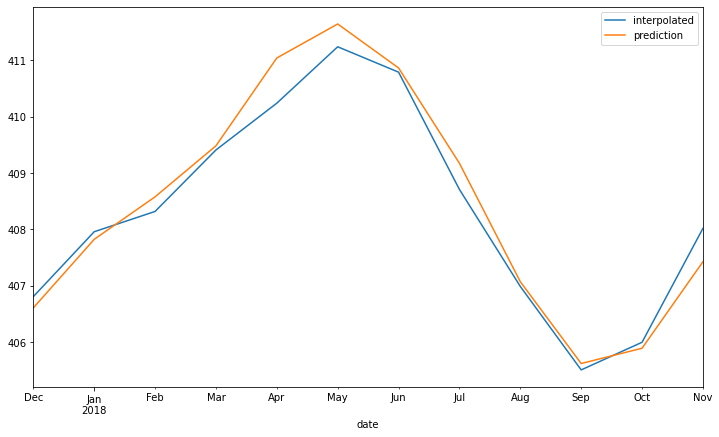

In [66]:
test["interpolated"].plot(legend=True,figsize=(12,7))
prediction.plot(legend=True)

In [67]:
fitted_model_whole=SARIMAX(data["interpolated"],order=(0,1,3),seasonal_order=(1,0,1,12)).fit()
# this time I train model with whole of my dataset cause i would like to preedict unknown future with my model!

In [69]:
prediction_unknown_future=fitted_model_whole.predict(start=len(data),end=len(data)+12,typ="levels").rename("unknow_future_prediction")

<AxesSubplot:xlabel='date'>

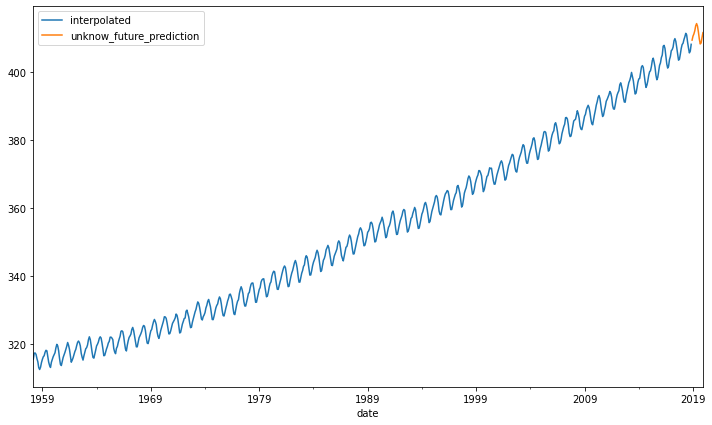

In [70]:
data["interpolated"].plot(figsize=(12,7),legend=True)
prediction_unknown_future.plot(legend=True)

In [78]:
from statsmodels.tools.eval_measures import rmse

In [79]:
rmse(test["interpolated"],prediction)

0.35809879064940286

In [80]:
test["interpolated"].mean()

408.3333333333333

In [81]:
prediction.mean()

408.4367990419167